In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle
import seaborn as sns
import pandas as pd
from itertools import product as prod
import proplot as pplt
from collections import defaultdict
from scipy.special import expit
from tqdm import tqdm
import itertools as it
from torch import nn
import argparse
import scipy
from scipy.sparse import linalg as splinalg
import scipy.sparse as sparse
import sys
from copy import deepcopy
from utils import inv_perm
import utils
from torch.utils.data import Dataset, DataLoader
from patsy import dmatrix
import yaml
import os
from utils import load_training_data, nbrs_avg, yearly
from models import UNetEncoder, Decoder, MeanOnlyDecoder
import torch
import torchvision.transforms.functional as vF
import numpy as np
from sksparse.cholmod import cholesky
from scipy import sparse
from utils import inv_perm


nd, nr, nc = 10, 128, 256
ksize = 13
dev = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(110104)
plt.rc("text", usetex=True)

d:\Github\weather2vec\conda-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from re import M
from tkinter import N
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor
from typing import Callable, Optional, List
from timm.models.layers import trunc_normal_


class PooledRegression:
    def __init__(
        self,
        Y: np.ndarray,
        X: np.ndarray = None,
        lam: float = 1.0,
        sample_lam: bool = True,
        seasonal: float = True,
    ):
        self.Y = Y
        self.X = X
        self.seasonal = seasonal
        self.has_covariates = (X is not None)

        self.nt, self.m = Y.shape  # number of reps, number of sites

        #  opts
        self.sample_lam = sample_lam
        self._sampling = True
        self.a = 1.0
        self.b = 1.0

        if self.has_covariates:
            self.d = X.shape[1]
            self.XtXsum = np.einsum("tdn, tfn -> df", self.X, self.X)
            self.lam = np.full((self.d,), lam)
            self.beta = np.zeros((self.d,))
        else:
            self.beta = 0.0
            self.lam = 0.0
            self.sample_lam = False


        # model params
        self.alpha = 0.0
        self.prec = 1.0
        self.ns = 12
        self.ny = self.nt // self.ns + (self.nt % self.ns != 0)
        self.delta = np.zeros((self.ny,))
        self.gamma = np.zeros((self.ns,))
        self.s = np.arange(self.nt) % self.ns
        self.y = np.arange(self.nt) // self.ns
        self.Mu = np.zeros_like(Y)

    def predict(self, X=None):
        if X is None:
            X = self.X
        out = (
            self.alpha 
            + self.delta[self.y, None]
            + self.gamma[self.s, None]
        )
        if self.has_covariates:
            out = out + np.einsum("tdn,d->tn", X, self.beta)
        return out

    def sampling(self):
        self._sampling = True

    def optimizing(self):
        self._sampling = False

    def prec_step(self):
        sse = np.square(self.Mu - self.Y)
        an = self.a + 0.5 * self.nt * self.m
        bn = self.b + 0.5 * sse.sum()
        if self._sampling:
            self.prec = np.random.gamma(an, 1.0 / bn)
        else:
            self.prec = (an - 1.0) / bn
        self.prec = np.clip(self.prec, 0.01, 1e6)

    def lam_step(self):
        ss = np.square(self.beta)
        an = self.a + 0.5
        bn = self.b + 0.5 * ss
        if self._sampling:
            self.lam = np.random.gamma(an, 1.0 / bn)
        else:
            self.lam = (an - 1.0) / bn

    def beta_step(self):
        old_beta_contrib = np.einsum("tdn,d->tn", self.X, self.beta)
        resid = self.Y - self.Mu + old_beta_contrib
        XtR = np.einsum("tdn,tn->d", self.X, resid)
        Q = self.XtXsum.copy()
        Q[np.diag_indices_from(Q)] += self.lam
        Sig = np.linalg.inv(Q)
        self.beta = Sig @ XtR
        if self._sampling:
            self.beta += np.random.multivariate_normal(np.zeros(self.d), Sig)
        # new_beta_contrib = np.einsum("tdn,d->tn", self.X, self.beta)
        # self.Mu += new_beta_contrib - old_beta_contrib
        self.Mu = self.predict()

    def delta_step(self):
        old_delta_contrib = self.delta[self.y, None]
        aux = self.Y - (self.Mu - old_delta_contrib)
        # print ((self.Mu - old_delta_contrib).mean())
        for i in range(1, self.ny):
            self.delta[i] = aux[
                (i * self.ns) : min(self.nt, (i + 1) * self.ns)
            ].mean()
            if self._sampling:
                self.delta[i] += np.random.randn() / np.sqrt(
                    self.prec * self.ns * self.m
                )
        # self.Mu += self.delta[self.y, None] - old_delta_contrib
        self.Mu = self.predict()

    def gamma_step(self):
        old_gamma_contrib = self.gamma[self.s, None]
        aux = self.Y - self.Mu + old_gamma_contrib
        for i in range(1, self.ns):
            self.gamma[i] = aux[i :: self.ns].mean()
            if self._sampling:
                self.gamma[i] += np.random.randn() / np.sqrt(
                    self.prec * self.ny * self.m
                )
        # self.Mu += self.gamma[self.s, None] - old_gamma_contrib
        self.Mu =  self.predict()

    def alpha_step(self):
        old_alpha = self.alpha
        resid = self.Y - self.Mu + self.alpha
        self.alpha = resid.mean()
        # self.alpha = self.Y.mean()
        if self._sampling:
            self.alpha += np.random.randn() / np.sqrt(
                self.prec * self.nt * self.m
            )
        # self.Mu += self.alpha - old_alpha
        self.Mu = self.predict()

    def mcmc_step(self):
        try:
            # self.Mu = self.predict()
            self.alpha_step()
            if self.has_covariates:
                self.beta_step()
                # pass
            self.delta_step()
            if self.ns > 0 and self.seasonal:
                self.gamma_step()
                # pass
            self.prec_step()
            if self.sample_lam and self.has_covariates:
                self.lam_step()
                # pass
        except:
            print(f"Error in mcmc_step, prec is {self.prec}")
            raise

    def opt_step(self):
        self.optimizing()
        self.mcmc_step()
        self.sampling()


In [4]:
class NARRData(Dataset):
    def __init__(self, path: str, nbr_av_size: int = 0, idxs: list = None, seasonal: bool = False):
        super().__init__()
        self.nbr_av_size = nbr_av_size
        self.seasonal = seasonal

        # load data
        C, _, Y, M = load_training_data(
            path, standardize_weather=True, log_so4=True, standardize_so4=True, year_averages=True 
        )
        *_, self.nr, self.nc = C.shape
        self.C = torch.FloatTensor(C)
        self.Y = torch.FloatTensor(Y)
        self.M = torch.FloatTensor(M).repeat((Y.shape[0], 1, 1))
        if idxs is not None:
            self.C = self.C[range(idxs[0], idxs[1])]
            self.Y = self.Y[range(idxs[0], idxs[1])]
            self.M = self.M[range(idxs[0], idxs[1])]

        # compute neighbor averages
        if nbr_av_size > 0:
            self.C = torch.cat([self.C, nbrs_avg(self.C, nbr_av_size)], 1)

    def __len__(self):
        return self.C.shape[0]

    def __getitem__(self, index):
        Ct = self.C[index]
        Yt = self.Y[index]
        Mt = self.M[index] 
        if self.seasonal:
            St = torch.ones_like(Yt) * (index % 12)
            Ct = torch.cat([Ct, St.unsqueeze(0)])
        return Ct, Yt, Mt

In [5]:
dirs = {
    "w2vec": "../results/supervised-so4/w2vec",
    "nbrs": "../results/supervised-so4/n9",
    "local": "../results/supervised-so4/local",
    # "Unadjusted": "../results/supervised-so4/unadjusted",
}

In [6]:
# Yhat = resdicts["w2vec"]["Yhat"]
# # Y = resdicts["w2vec"]["Y"]
# C = resdicts["w2vec"]["C"]

In [7]:
# resdicts.keys()

In [8]:
# plt.imshow(Yhat[-1])

In [9]:
from collections import defaultdict

resdicts = defaultdict(dict)
for key, D in dirs.items():
    args = argparse.Namespace()
    with open(os.path.join(D, "args.yaml"), "r") as io:
        for k, v in yaml.load(io, Loader=yaml.FullLoader).items():
            setattr(args, k, v)
            if k == "nbrs_av":
                setattr(args, "av_nbrs", v)
            elif k == "av_nbrs":
                setattr(args, "nbrs_av", v)
        if not hasattr(args, "seasonal"):
            args.seasonal = False
    dev = args.device if torch.cuda.is_available() else "cpu"
    dws = dict(num_workers=args.nworkers, pin_memory=True)
    full_dataset = NARRData('../data/training_data.pkl', args.av_nbrs, seasonal=args.seasonal)
    _, nd, *_ = full_dataset.C.shape
    if args.seasonal:
        nd += 1
    nt, nd, nr, nc = full_dataset.C.shape
    full_loader = DataLoader(full_dataset, 1, shuffle=False, **dws)

    bn_type ="frn" if not hasattr(args, "bn_type") else args.bn_type
    mkw = dict(
        n_hidden=args.nhidden,
        depth=args.depth,
        num_res=args.nres,
        ksize=args.ksize,
        groups=args.groups,
        batchnorm=True,
        depthwise=args.depthwise,
        batchnorm_type=args.bntype
    )
    dkw = dict(batchnorm=True, offset=False, batchnorm_type=args.bntype)
    if args.unadjusted:
        enc = nn.Identity()
        dec = MeanOnlyDecoder().to(dev)
    elif args.local or args.av_nbrs > 0:
        enc = nn.Identity()
        dec = Decoder(nd, 1, args.nhidden_dec, n_res=args.nres_dec, **dkw).to(dev)
    else:
        enc = UNetEncoder(nd, args.nhidden, **mkw).to(dev)
        dec = Decoder(args.nhidden, 1, args.nhidden_dec, n_res=0, **dkw).to(dev)

    mod = nn.ModuleDict(dict(enc=enc, dec=dec))
    mod.load_state_dict(torch.load(os.path.join(D, "model.pt")))
    mod.eval()

    Yhat = []
    C = []
    Y = []

    for sample in tqdm(full_loader):
        C_, Y_, M_ = [x.to(dev) for x in sample]
        Z = mod["enc"](C_)
        Yhat_ = mod["dec"](Z).squeeze(1)
        Yhat.append(Yhat_.detach().cpu().numpy())
        C.append(C_.detach().cpu().numpy())
        Y.append(Y_.detach().cpu().numpy())
    Yhat = np.concatenate(Yhat, axis=0)
    C = np.concatenate(C, axis=0)
    Y = np.concatenate(Y, axis=0)
    resdicts[key]["C"] = C
    resdicts[key]["Y"] = Y
    resdicts[key]["Yhat"] = Yhat

100%|██████████| 180/180 [00:06<00:00, 29.88it/s]


In [10]:
_, _, Yraw, M, ppdata = load_training_data(
    "../data/training_data.pkl", standardize_weather=True, log_so4=False, standardize_so4=False, return_pp_data=True 
)

In [11]:
ppdata = ppdata.sort_values("so2_tons", ascending=False).iloc[:473]
ppdata

,fid,lon,lat,so2_tons,col,row
546,3149,-76.6672,41.0714,2444975.213,199,43
502,2872,-81.6797,39.5908,2380213.938,181,49
144,703,-84.9192,34.1256,2369897.500,170,71
535,3136,-79.3411,40.6604,2318207.073,189,45
530,3122,-79.1968,40.5110,2292317.120,190,45
...,...,...,...,...,...,...
857,7504,-105.3841,44.2853,10704.237,101,30
450,2531,-75.4792,42.2768,10536.864,203,38
1081,50202,-79.0082,43.0804,10418.767,191,35
1129,50835,-86.2906,44.2170,10355.032,166,31


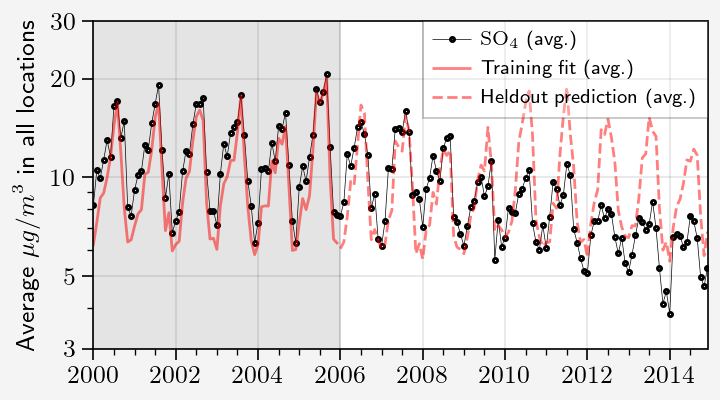

In [12]:
# fig, ax = pplt.subplots([1, 2], figsize=(7.2, 2.1))
fig, ax = pplt.subplots([1], figsize=(3.6, 2.0), yscale="log")
# ax.format(yscale="log")
# ls = ["-", "--", "-.", ":"]
ls = ["-", "-", "--", ":"]

yhat = Yhat
ix = np.where(M)
mu, sig = np.log(Yraw[ix] + 1).mean(), np.log(Yraw[ix] + 1).std()
yhat = (yhat - yhat[ix].mean()) / yhat[ix].std() * sig + mu
yhat = np.exp(Yhat) - 1
ytot = 1000 * (M * Yraw).sum((1, 2)) / M.sum()
yhat = 1000 * (M * yhat).sum((1, 2)) / M.sum()
yhat = (yhat - yhat.mean()) / yhat.std() * ytot.std() + ytot.mean()
x = np.linspace(2000, 2015 - 1/12, len(ytot))
ax.plot(x, ytot, lw=0.25, c="black", label="$\\textrm{SO}_4$ (avg.)", marker="o", ms=1.5, facecolors="none", edgecolors="black")
plt.plot(x[:(6 * 12)], yhat[:(6 * 12)], lw=1.0, label="Training fit (avg.)", c="red", alpha=0.5)
plt.plot(x[(6 * 12):], yhat[(6 * 12):], lw=1.0, label="Heldout prediction (avg.)", c="red", alpha=0.5, ls="--")
ax.set_yticks(ticks=[3.0, 5.0, 10.0, 20.0, 30.0])
ax.set_ylabel("Average $\\mu g/m^3$ in all locations")
ax.axvspan(2000, 2006, alpha=0.25, color='grey')
ax.legend(loc="ur", framealpha=0.25, prop={"size": 7}, ncol=1)
ax.set_ylim(3, 30)
plt.savefig("../figures/prognostic_score.png", bbox_inches="tight")
plt.savefig("../figures/prognostic_score.pdf", bbox_inches="tight")

In [13]:
def make_covars(X_):
    nt, d = X_.shape[:2]
    Xs = [dmatrix("bs(x, 3) - 1", {"x": X_[:, j].reshape(-1)}) for j in range(d)]
    X_ = np.concatenate([_.reshape(nt, -1, 3).transpose(0, 2, 1) for _ in Xs], axis=1)
    return X_

def train_and_collect_posterior(model, mcmc_burn=500, mcmc_thin=4, mcmc_samples=100):
# def train_and_collect_posterior(model, mcmc_burn=1000, mcmc_thin=8, mcmc_samples=125):
    pars = ["alpha", "beta", "delta", "lam", "prec", "gamma", "Mu"]
    post = defaultdict(list)

    print("Burn-in (mixing)...")
    for i in tqdm(range(mcmc_burn)):
        model.mcmc_step()

    print("Sampling...")
    for i in tqdm(range(mcmc_samples * mcmc_thin)):
        model.mcmc_step()
        if i % mcmc_thin == 0:
            for par in pars:
                post[par].append(deepcopy(getattr(model, par)))

    posterior = dict()
    for k in ["alpha", "beta", "delta", "prec", "lam", "gamma", "Mu"]:
        v = post[k]
        posterior[k] = np.stack(v).astype(np.float32)

    return posterior

In [14]:
row = ppdata.row.values
col = ppdata.col.values

for k, D in dirs.items():
    Yhat = resdicts[k]["Yhat"]
    Y = resdicts[k]["Y"]
    C = resdicts[k]["C"]
    resdicts[k]["Y_"] = Y[..., row, col]
    resdicts[k]["Xloc"] = C[..., row, col]
    resdicts[k]["Xneigh"] = utils.nbrs_avg(torch.FloatTensor(C), radius=9).numpy()[..., row, col]
    resdicts[k]["Xprog"] = Yhat[..., row, col][:, None]

# Y_ = resdicts["w2vec"]["Y_"]
# Xloc = resdicts["w2vec"]["Xloc"]
# Xneigh = resdicts["w2vec"]["Xneigh"]
# Xprog = resdicts["w2vec"]["Xprog"]

In [15]:
posteriors = {}

In [16]:
#unadjusted
model = PooledRegression(resdicts['w2vec']["Y_"])
posteriors["Unadjusted"] = train_and_collect_posterior(model)

Burn-in (mixing)...


100%|██████████| 500/500 [00:01<00:00, 456.83it/s]


Sampling...


100%|██████████| 400/400 [00:00<00:00, 491.81it/s]


In [30]:
# local
# X_ = make_covars(Xloc)
# model = PooledRegression(Y_, X_)
# model = PooledRegression(Y_, np.random.normal(size=X_.shape))
# local + neighbors

prog_all = False

for k, D in resdicts.items():
    confs = [D["Xloc"]]
    if k != "local":
        confs.append(D['Xneigh'])
    if "w2vec" in k or prog_all:
        confs.append(D['Xprog'])
    X_ = make_covars(np.concatenate(confs, axis=1))
    model = PooledRegression(resdicts['w2vec']["Y_"], X_)
    posteriors[k] = train_and_collect_posterior(model)

Burn-in (mixing)...


100%|██████████| 500/500 [00:20<00:00, 24.12it/s]


Sampling...


100%|██████████| 400/400 [00:15<00:00, 25.54it/s]


Burn-in (mixing)...


100%|██████████| 500/500 [00:32<00:00, 15.21it/s]


Sampling...


100%|██████████| 400/400 [00:26<00:00, 15.33it/s]


Burn-in (mixing)...


100%|██████████| 500/500 [00:09<00:00, 52.28it/s]


Sampling...


100%|██████████| 400/400 [00:07<00:00, 53.87it/s]


In [31]:
# # local + neighbors
# X_ = make_covars(np.concatenate([Xloc, Xneigh], axis=1))
# model = PooledRegression(Y_, X_)
# posteriors["Local + 300km avg."] = train_and_collect_posterior(model)

In [32]:
so2_full = pd.read_csv("../data/so2_data_full.csv")
so2_full

,fid,lat,lon,year,month,fuel_type,operating_time,heat_input,so2_tons,.groups,na_streak,op_is_zero,zero_streak
0,3,31.0069,-88.0103,1997,1,Coal,3292.50,9330063.025,5903.060,drop,0,0,0
1,3,31.0069,-88.0103,1997,2,Coal,2690.50,8083510.675,5183.229,drop,0,0,0
2,3,31.0069,-88.0103,1997,3,Coal,3197.00,8991255.175,5967.067,drop,0,0,0
3,3,31.0069,-88.0103,1997,4,Coal,2974.25,6878179.201,4585.946,drop,0,0,0
4,3,31.0069,-88.0103,1997,5,Coal,3360.75,9731574.575,6504.081,drop,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
310414,880101,34.8380,-85.7865,2014,5,Pipeline Natural Gas,706.00,190620.000,0.000,drop,0,0,0
310415,880101,34.8380,-85.7865,2014,6,Pipeline Natural Gas,610.00,164700.000,0.000,drop,0,0,0
310416,880101,34.8380,-85.7865,2014,7,Pipeline Natural Gas,711.00,191970.000,0.000,drop,0,0,0
310417,880101,34.8380,-85.7865,2014,8,Pipeline Natural Gas,688.00,185760.000,0.000,drop,0,0,0


In [33]:
so2_full.fuel_type.unique()

array(['Coal', 'Pipeline Natural Gas', 'Coal, Pipeline Natural Gas', nan,
       'Natural Gas, Pipeline Natural Gas', 'Natural Gas',
       'Diesel Oil, Residual Oil, Pipeline Natural Gas',
       'Diesel Oil, Pipeline Natural Gas', 'Other Gas',
       'Other Gas, Pipeline Natural Gas', 'Diesel Oil',
       'Diesel Oil, Other Oil', 'Other Oil', 'Residual Oil', 'Wood',
       'Residual Oil, Pipeline Natural Gas', 'Coal, Natural Gas',
       'Diesel Oil, Other Gas', 'Process Gas',
       'Other Oil, Pipeline Natural Gas', 'Residual Oil, Other Oil',
       'Coal, Wood', 'Diesel Oil, Residual Oil',
       'Other Oil, Petroleum Coke', 'Petroleum Coke', 'Coal Refuse',
       'Other Solid Fuel', 'Coal, Other Gas', 'Coal, Coal Refuse',
       'Other Solid Fuel, Wood', 'Tire Derived Fuel',
       'Residual Oil, Process Gas', 'Other Gas, Process Gas',
       'Pipeline Natural Gas, Process Gas',
       'Other Oil, Tire Derived Fuel', 'Natural Gas, Process Gas'],
      dtype=object)

In [34]:
so2_full = so2_full[so2_full.fid.isin(ppdata.fid) & (so2_full.year >= 2000) & (so2_full.year <= 2014) & (so2_full.fuel_type.str.contains("Coal")) & (so2_full.operating_time > 0.0)]
so2_monthly = so2_full.groupby(['year', 'month']).agg({"so2_tons": sum}).reset_index()
so2_monthly["so2_tons_log"] = np.log(so2_monthly.so2_tons)
so2_monthly

,year,month,so2_tons,so2_tons_log
0,2000,1,973771.423,13.788932
1,2000,2,859282.666,13.663853
2,2000,3,836848.915,13.637399
3,2000,4,750452.215,13.528431
4,2000,5,834334.684,13.634390
...,...,...,...,...
175,2014,8,335914.591,12.724612
176,2014,9,284371.686,12.558037
177,2014,10,240407.347,12.390090
178,2014,11,267325.648,12.496223


In [35]:
namedict = {
    'local': 'Local',
    'w2vec': 'W2V-Prognostic',
    'Unadjusted': 'Unadjusted',
    'nbrs': 'Local+300km avs.'
}

In [36]:
so2_full = pd.read_csv("../data/so2_data_full.csv")
so2_full = so2_full[so2_full.fid.isin(ppdata.fid) & (so2_full.year >= 2000) & (so2_full.year <= 2014) & (so2_full.fuel_type == "Coal") & (so2_full.operating_time > 0.0)]
so2_yearly = so2_full.groupby('year').agg({"so2_tons": sum}).reset_index()
so2_yearly["so2_tons_log"] = np.log(so2_yearly.so2_tons)
so2_yearly.shape

(15, 3)

In [37]:
posteriors.keys()

dict_keys(['Unadjusted', 'w2vec', 'nbrs', 'local'])

Unadjusted
w2vec
nbrs
local
check
(180,)
(180,)


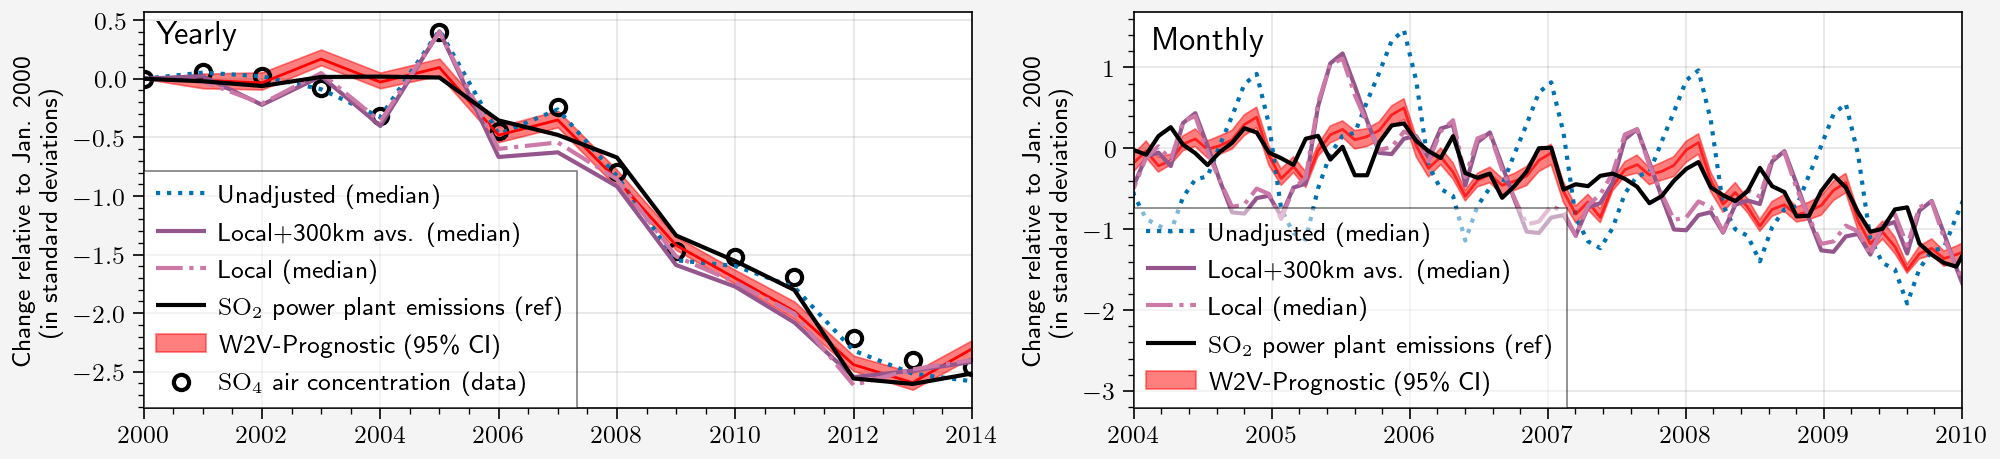

In [38]:
fig, ax = pplt.subplots(nrows=1, ncols=2, figsize=(10, 2.3), share=False)
markers = ["X", "s", "o", "^", "v"]
ls = [":", "--", "-", "-.", "-"]
colors = ['#0072b2', '#009e73',  'purple', '#cc79a7', '#f0e442']

Y_ = resdicts['w2vec']["Y_"]
ytot = (Y_).sum(-1)
for i, (k, post) in enumerate(posteriors.items()):
    if k not in namedict:
        continue
    print(k)
    # visualize a few samples of delta across locations
    # yeff = (mask * posterior["delta"]).sum((2, 3)).T
    yeff = post["delta"].T
    # yeff = yeff - yeff.mean() + Y_.mean()
    yeffm = np.quantile(post["delta"], 0.5, 0)
    # print(yeffm)
    # print(post["delta"])
    # print(f"alpha: {post['alpha'].mean():.2f}, std.err: {np.sqrt(1/post['prec']).mean():.2f}, lam: {post['lam'].mean():.2f}")
    # seff = posterior["gamma"].sum((2, 3)).T
    # yeff = yeff[model.y]
    # seff = seff[model.s]
    # y2eff = yeff + seff
    yeff = (yeff - yeff[0]) / yeff.std()
    yeffm = (yeffm - yeffm[0]) / yeffm.std()
    # y2eff = (y2eff - y2eff.mean(0)) / y2eff.std(0)
    # print(yeff.shape)
    # ytot = (Y[..., row, col]).sum(-1)
    x = np.linspace(2000, 2000 + ytot.shape[0] // 12, ytot.shape[0]) 
    # plt.plot(x, yeff, c="black", alpha=0.05)
    # print(yeff.shape)
    # yeff = np.concatenate([yeff, yeff[-1:]])
    # print(yeff.shape)
    yup = np.quantile(yeff, 0.975, -1) + 0.001
    ylo = np.quantile(yeff, 0.025, -1)
    # ribbon plot
    if "w2vec" in k:
        ax[0].fill_between(range(2000, 2015), ylo, yup, c="red", label=namedict[k] + " (95\\% CI)", alpha=0.5)
        ax[0].plot(range(2000, 2015), yeffm, c="red", lw=1.0)
    else:
        ax[0].plot(range(2000, 2015), yeffm, label=namedict[k] + " (median)", c=colors[i], ls=ls[i], lw=1.5)
    # for j in range(yeff.shape[1]):
    #     plt.plot(range(2000, 2015), yeff[:-1, j], c="black", alpha=0.05)
    x_ = range(2000, 2015)
print('check')
# ytot = (ytot - ytot.mean(0)) / ytot.std(0)

yytot = yearly(ytot)
yytot = (yytot - yytot[0]) / yytot.std()
so2 =so2_yearly.so2_tons_log.values
so2 = (so2 - so2[0]) / so2.std()
ax[0].scatter(x_, yytot[:-1], s=30, lw=1.5, facecolors='none', edgecolors='black', label="$\\textrm{SO}_4$ air concentration (data)")
ax[0].plot(x_, so2, s=30, lw=1.5, facecolors='none', c='black', label="$\\textrm{SO}_2$ power plant emissions (ref)")
# yso2 = (yso2 - yso2.mean()) / yso2.std()
# plt.plot(x_, yso2[:-1], c="red")
# plt.title("Mean year effect")
ax[0].legend(ncol=1, framealpha=0.5, loc="ll")
ax[0].set_ylabel("Change relative to Jan. 2000\n(in standard deviations)")
ax[0].text(2000.2, 0.3, "Yearly", fontdict={'size': 12})
# ax[0].savefig("../figures/app2_yearly.png", bbox_inches="tight")


ytot = (Y_).sum(-1)
x_ = np.linspace(2000, 2000 + ytot.shape[0] // 12 + 1 - 1/12, nt) 

for i, (k, post) in enumerate(posteriors.items()):
    # visualize a few samples of delta across locations
    # yeff = (mask * posterior["delta"]).sum((2, 3)).T
    yeff = post["delta"][:, model.y].T + post["gamma"][:, model.s].T
    # yeff = yeff - yeff.mean() + Y_.mean()
    yeffm = np.quantile(yeff, 0.5, 1)
    yeff = (yeff - yeff[:12].mean()) / yeff.std()
    yeffm = (yeffm - yeffm[:12].mean()) / yeffm.std()
    # y2eff = (y2eff - y2eff.mean(0)) / y2eff.std(0)
    # print(yeff.shape)
    # ytot = (Y[..., row, col]).sum(-1)
    
    # plt.plot(x, yeff, c="black", alpha=0.05)
    # print(yeff.shape)
    # yeff = np.concatenate([yeff, yeff[-1:]])
    # print(yeff.shape)
    yup = np.quantile(yeff, 0.975, -1) + 0.001
    ylo = np.quantile(yeff, 0.025, -1)
    # ribbon plot
    if "w2vec" in k:
        ax[1].fill_between(x_, ylo, yup, c="red", label=namedict[k] + " (95\\% CI)", alpha=0.5)
        ax[1].plot(x_, yeffm, c="red", alpha=0.75, lw=1)
    else:
        ax[1].plot(x_, yeffm, label=namedict[k] + " (median)", c=colors[i], ls=ls[i], lw=1.5)
    # for j in range(yeff.shape[1]):
    #     plt.plot(range(2000, 2015), yeff[:-1, j], c="black", alpha=0.05)
# ytot = (ytot - ytot.mean(0)) / ytot.std(0)

# yytot = yearly(ytot)
yytot = ytot
print(yytot.shape)
print(x_.shape)
yytot = (yytot - yytot[:12].mean()) / yytot.std()
so2 = so2_monthly.so2_tons_log.values
so2 = (so2 - so2[:12].mean()) / so2.std()
# plt.scatter(x_, yytot, s=30, lw=1.5, facecolors='none', edgecolors='black', label="$\\textrm{SO}_4$ air concentration (data)")
plt.plot(x_, so2, s=30, lw=1.5, facecolors='none', c='black', label="$\\textrm{SO}_2$ power plant emissions (ref)")
# yso2 = (yso2 - yso2.mean()) / yso2.std()
# plt.plot(x_, yso2[:-1], c="red")
# plt.title("Mean year effect")
ax[1].legend(ncol=1, framealpha=0.5, loc="ll")
ax[1].set_ylabel("Change relative to Jan. 2000\n(in standard deviations)")
ax[1].set_xlim(2004, 2010)
ax[1].text(2004.15, 1.22, "Monthly", fontdict={'size': 12})

plt.savefig("../figures/app2.png", bbox_inches="tight")